In [1]:
import librosa
import os
import re

'''
Φτιάξτε μία συνάρτηση (data parser) που να διαβάζει όλα τα αρχεία ήχου που δίνονται μέσα στο φάκελο digits/
και να επιστρέφει 3 λίστες Python, που να περιέχουν: Το wav που διαβάστηκε με librosa, τον αντίστοιχο ομιλητή
και το ψηφίο

'''


def data_parser(directory):
    wavs = []
    speakers = []
    digits = []
    
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        wav , sr = librosa.load(filepath, sr=16000)
        wavs.append(wav)
        
        # Εξαγωγή ψηφίου και ομιλητή από το όνομα του αρχείου
        name_part = filename.split('.')[0]
        match = re.match(r"([a-zA-Z]+)(\d+)", name_part)
        if match:
            digits.append(match.group(1))
            speakers.append(int(match.group(2)))
        else:
            digits.append(None)
            speakers.append(None)
            
    return wavs, speakers, digits


In [2]:
'''
Εξάγετε με το librosa τα Mel-Frequency Cepstral Coefficients (MFCCs) για κάθε αρχείο ήχου. Εξάγετε 13
χαρακτηριστικά ανά αρχείο. Χρησιμοποιήστε μήκος παραθύρου 25 ms και βήμα 10 ms. Επίσης, υπολογίστε και
την πρώτη και δεύτερη τοπική παράγωγο των χαρακτηριστικών, τις λεγόμενες deltas και delta-deltas (hint:
υπάρχει έτοιμη υλοποίηση στο librosa).
'''

import librosa

def extract_mfccs(wavs):
    mfccs = []
    
    for wav in wavs:
        mfcc = librosa.feature.mfcc(y=wav, sr=16000, n_mfcc=13, n_fft=400, hop_length=160)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        
        mfccs.append((mfcc, delta, delta2))
        
    return mfccs





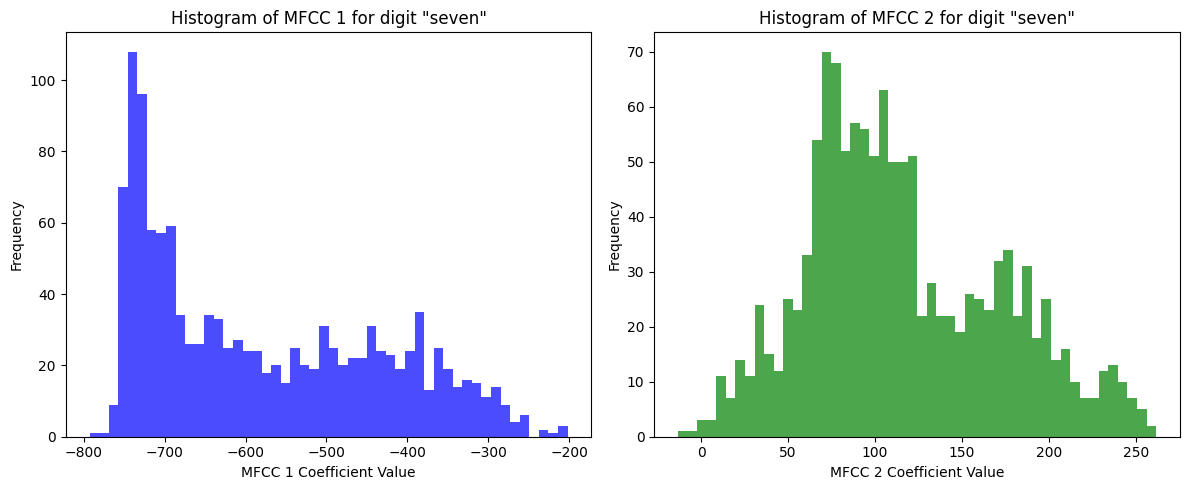

Digit "seven":
Variance of MFCC 1: 21497.80
Variance of MFCC 2: 3068.08



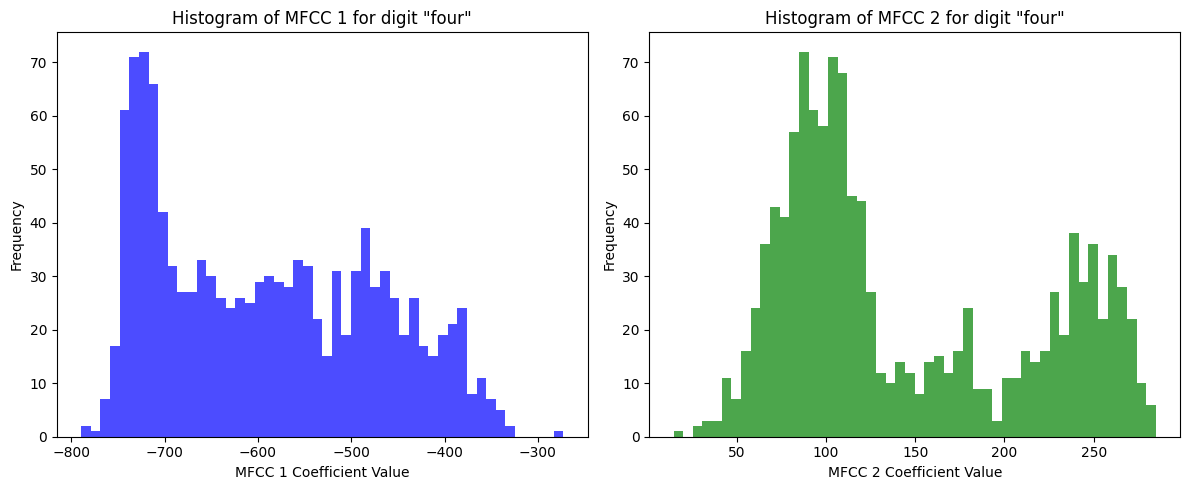

Digit "four":
Variance of MFCC 1: 14009.79
Variance of MFCC 2: 4906.44



In [3]:
'''
Αναπαραστήστε τα ιστογράμματα του 1ου και του 2ου MFCC των ψηφίων n1 (7) και n2 (4) για όλες τους τις
εκφωνήσεις. Πόση απόκλιση υπάρχει?
'''

import librosa
import numpy as np

#from step2 import data_parser
#from step3 import extract_mfccs
import matplotlib.pyplot as plt

# Step 2: Load data
wavs, speakers, digit_labels = data_parser('./data/digits/')

# Step 3: Extract MFCCs
mfccs_list = extract_mfccs(wavs)

# Digits to analyze
digits_to_analyze = ['seven', 'four']

# Collect MFCC coefficients for each digit
digit_mfccs = {digit: {'mfcc1': [], 'mfcc2': []} for digit in digits_to_analyze}

for idx, digit in enumerate(digit_labels):
    if digit in digits_to_analyze:
        mfcc, delta, delta2 = mfccs_list[idx]
        # Collect the 1st and 2nd MFCC coefficients across all frames
        digit_mfccs[digit]['mfcc1'].extend(mfcc[0].flatten())
        digit_mfccs[digit]['mfcc2'].extend(mfcc[1].flatten())

# Plot histograms
for digit in digits_to_analyze:
    mfcc1_values = np.array(digit_mfccs[digit]['mfcc1'])
    mfcc2_values = np.array(digit_mfccs[digit]['mfcc2'])

    plt.figure(figsize=(12, 5))

    # Histogram for MFCC 1
    plt.subplot(1, 2, 1)
    plt.hist(mfcc1_values, bins=50, color='blue', alpha=0.7)
    plt.title(f'Histogram of MFCC 1 for digit "{digit}"')
    plt.xlabel('MFCC 1 Coefficient Value')
    plt.ylabel('Frequency')

    # Histogram for MFCC 2
    plt.subplot(1, 2, 2)
    plt.hist(mfcc2_values, bins=50, color='green', alpha=0.7)
    plt.title(f'Histogram of MFCC 2 for digit "{digit}"')
    plt.xlabel('MFCC 2 Coefficient Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    
    # Save the histograms
    plt.savefig(f'images/histograms_{digit}.png')
    plt.show()


    # Calculate and print variance
    variance_mfcc1 = np.var(mfcc1_values)
    variance_mfcc2 = np.var(mfcc2_values)
    print(f'Digit "{digit}":')
    print(f'Variance of MFCC 1: {variance_mfcc1:.2f}')
    print(f'Variance of MFCC 2: {variance_mfcc2:.2f}\n')

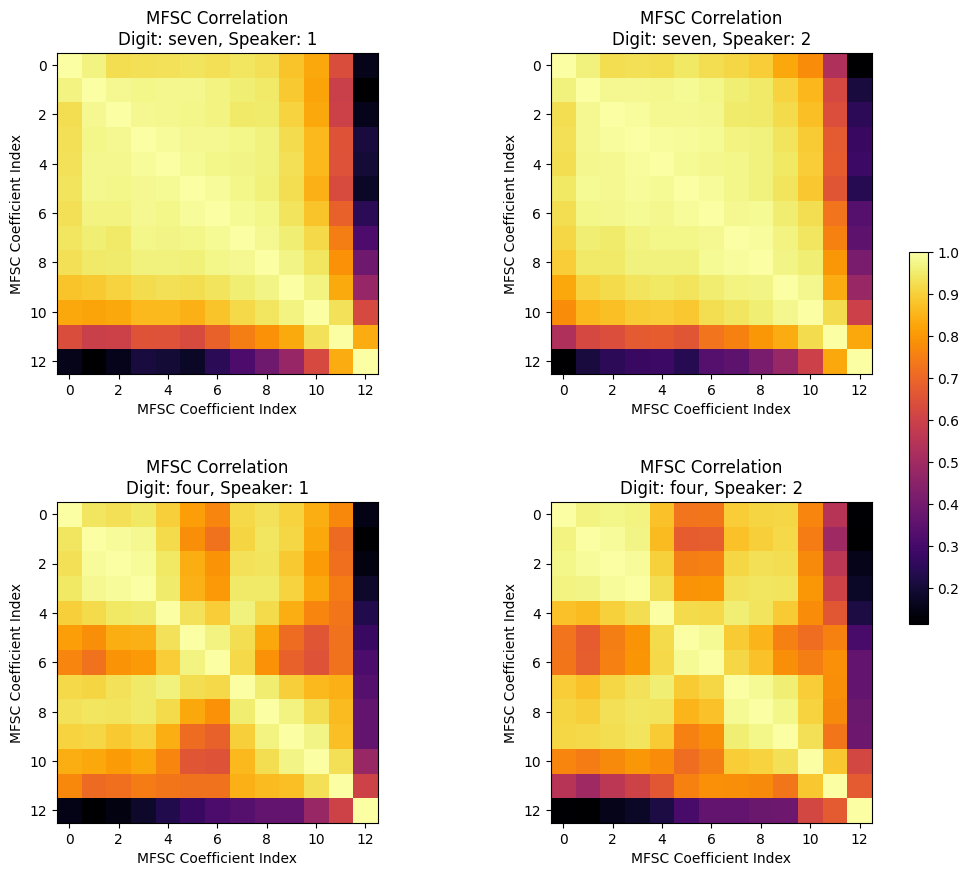

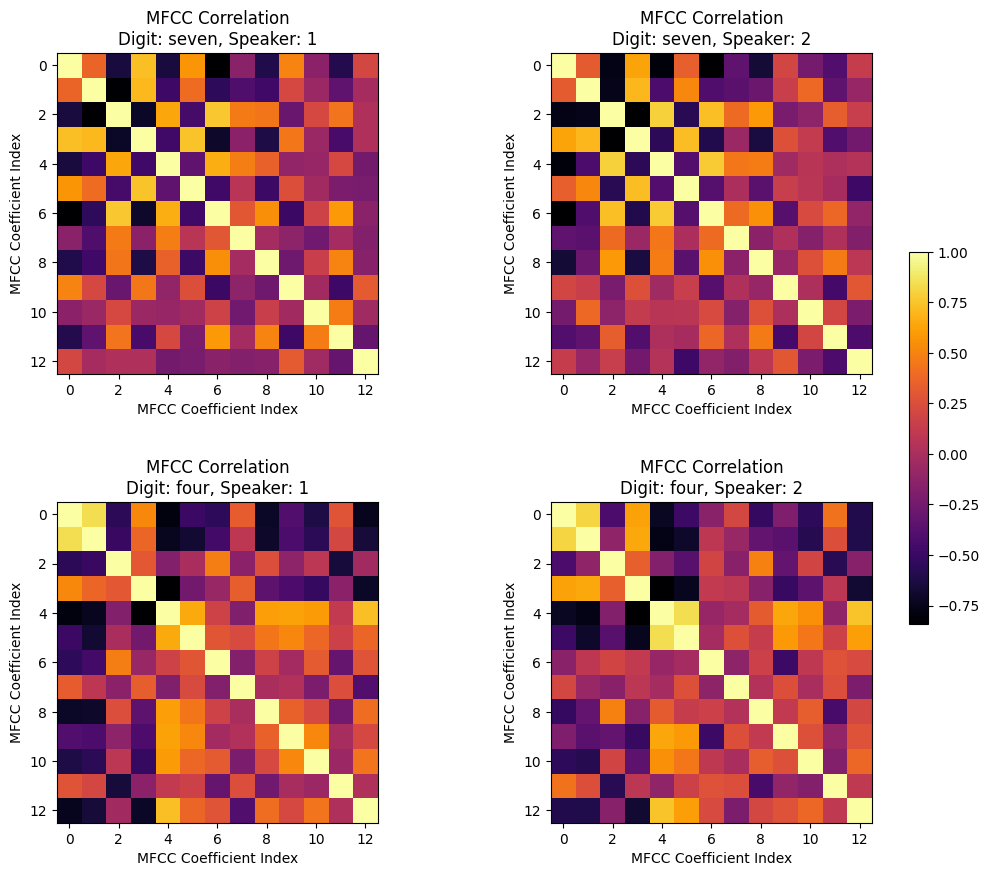

In [4]:
# Build a mapping from (digit, speaker) to index
utterances = {}

for idx, (digit, speaker) in enumerate(zip(digit_labels, speakers)):
    key = (digit, speaker)
    if key not in utterances:
        utterances[key] = idx

# Select indices for 'seven' and 'four' spoken by speakers 1 and 2
selected_indices = [
    utterances.get(('seven', 1)),
    utterances.get(('seven', 2)),
    utterances.get(('four', 1)),
    utterances.get(('four', 2))
]

def process_utterance(wav):
    # Compute MFSCs (log Mel spectrogram)
    S = librosa.feature.melspectrogram(
        y=wav,
        sr=16000,
        n_fft=int(0.025 * 16000),    # 25 ms window
        hop_length=int(0.010 * 16000), # 10 ms hop
        n_mels=13
    )
    log_S = librosa.power_to_db(S)

    # Compute MFCCs from the log Mel spectrogram
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

    return log_S, mfcc


# Define the number of utterances and the grid layout
num_utterances = len(selected_indices)
cols = 2  # Number of columns
rows = (num_utterances + 1) // cols  # Calculate rows based on number of utterances

# Initialize figures for MFSCs and MFCCs
fig_mfsc, axes_mfsc = plt.subplots(rows, cols, figsize=(12, 5 * rows))
fig_mfcc, axes_mfcc = plt.subplots(rows, cols, figsize=(12, 5 * rows))

# Flatten axes for easy indexing
axes_mfsc = axes_mfsc.flatten()
axes_mfcc = axes_mfcc.flatten()

# Loop over each selected utterance
for i, idx in enumerate(selected_indices):
    if idx is not None:
        wav = wavs[idx]
        digit = digit_labels[idx]
        speaker = speakers[idx]

        # Extract MFSCs and MFCCs
        mfsc, mfcc = process_utterance(wav)

        # Compute correlation matrices
        corr_mfsc = np.corrcoef(mfsc)
        corr_mfcc = np.corrcoef(mfcc)

        # Plot correlation matrix for MFSCs
        ax_mfsc = axes_mfsc[i]
        ax_mfsc.imshow(corr_mfsc, interpolation='nearest', cmap='inferno')
        ax_mfsc.set_title(f'MFSC Correlation\nDigit: {digit}, Speaker: {speaker}')
        ax_mfsc.set_xlabel('MFSC Coefficient Index')
        ax_mfsc.set_ylabel('MFSC Coefficient Index')

        # Plot correlation matrix for MFCCs
        ax_mfcc = axes_mfcc[i]
        ax_mfcc.imshow(corr_mfcc, cmap='inferno', interpolation='nearest')
        ax_mfcc.set_title(f'MFCC Correlation\nDigit: {digit}, Speaker: {speaker}')
        ax_mfcc.set_xlabel('MFCC Coefficient Index')
        ax_mfcc.set_ylabel('MFCC Coefficient Index')
    else:
        print('Selected index not found.')

# Hide any empty subplots
for j in range(i + 1, len(axes_mfsc)):
    axes_mfsc[j].axis('off')
    axes_mfcc[j].axis('off')

# Adjust layout for spacing between subplots
fig_mfsc.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust vertical (hspace) and horizontal (wspace) spacing
fig_mfcc.subplots_adjust(hspace=0.4, wspace=0.3)

# Add colorbars and set figure titles
fig_mfsc.colorbar(axes_mfsc[0].images[0], ax=axes_mfsc[:i + 1], orientation='vertical', fraction=0.02, pad=0.04)
fig_mfcc.colorbar(axes_mfcc[0].images[0], ax=axes_mfcc[:i + 1], orientation='vertical', fraction=0.02, pad=0.04)

# Save the combined figures
fig_mfsc.savefig('images/corr_mfsc_combined.png')
fig_mfcc.savefig('images/corr_mfcc_combined.png')

plt.show()

C:\Users\30694\AppData\Local\Temp\ipykernel_12844\636074702.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_digits))


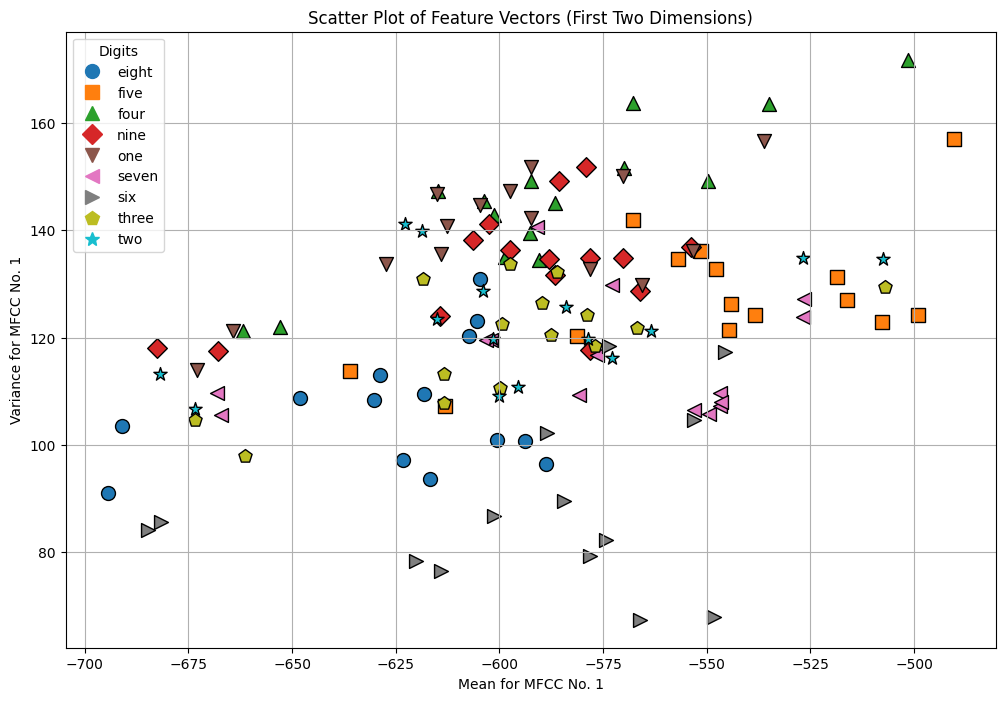

In [5]:
# Βήμα 5
# Step 2: Load data
wavs, speakers, digits = data_parser('./data/digits/')

# Step 3: Extract MFCCs
mfccs = extract_mfccs(wavs)

'''
Feature Extraction
'''
def compute_feature_vectors(mfccs):
    """
    Processes audio files in the specified directory to extract feature vectors.

    Parameters:
    - mfccs (list): List of tuples, each containing MFCCs, deltas, and delta-deltas for an audio file.

    Returns:
    - feature_vectors (np.ndarray): Array of feature vectors (shape: [num_utterances, 78]).
    - labels (list): List of digit labels corresponding to each feature vector.
    """
    
    # Step 3: Initialize lists to store feature vectors and corresponding labels
    feature_vectors = []
    labels = []
    
    for idx, (mfcc, delta, delta2) in enumerate(mfccs):
        # Concatenate MFCCs, Deltas, and Delta-Deltas along the feature axis
        combined_features = np.concatenate((mfcc, delta, delta2), axis=0)  # Shape: (39, frames)
        
        # Compute mean and standard deviation for each feature across all frames
        mean_features = np.mean(combined_features, axis=1)  # Shape: (39,)
        std_features = np.std(combined_features, axis=1)    # Shape: (39,)
        
        # Concatenate mean and std to form a single feature vector (total length: 78)
        feature_vector = np.concatenate((mean_features, std_features))  # Shape: (78,)
        
        # Append to the list of feature vectors
        feature_vectors.append(feature_vector)
        
        # Append the corresponding digit label
        labels.append(digits[idx])
    
    # Convert the list of feature vectors to a NumPy array for easier manipulation
    feature_vectors = np.array(feature_vectors)  # Shape: (num_utterances, 78)
    
    return feature_vectors, labels


feature_vectors, labels = compute_feature_vectors(mfccs)

'''
Prepare for visualization
'''

def assign_colors_markers(labels):
    """
    Identifies unique digits and assigns unique colors and markers to each digit.
    
    Parameters:
    - labels (list): List of digit labels corresponding to each data point.
    
    Returns:
    - unique_digits (list): Sorted list of unique digit labels.
    - digit_to_color (dict): Mapping from each digit to a unique color.
    - digit_to_marker (dict): Mapping from each digit to a unique marker.
    """
    # Identify unique digits in the dataset
    unique_digits = sorted(set(labels))
    
    # Assign unique colors and markers to each digit
    colors = plt.cm.get_cmap('tab10', len(unique_digits))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']  # Extend or modify as needed
    
    digit_to_color = {digit: colors(idx) for idx, digit in enumerate(unique_digits)}
    digit_to_marker = {digit: markers[idx % len(markers)] for idx, digit in enumerate(unique_digits)}
    
    return unique_digits, digit_to_color, digit_to_marker


unique_digits, digit_to_color, digit_to_marker = assign_colors_markers(labels)

'''
Scatterplot of feature vectors
'''

# Initialize the plot
plt.figure(figsize=(12, 8))

for idx, feature_vector in enumerate(feature_vectors):
    digit = labels[idx]
    color = digit_to_color[digit]
    marker = digit_to_marker[digit]
    
    # Extract the first two dimensions (mean of the first two features)
    x = feature_vector[0]  # Mean of first feature
    y = feature_vector[1]  # Mean of second feature
    
    # Plot the point
    plt.scatter(x, y, color=color, marker=marker, label=digit, edgecolors='k', s=100)

# Create custom legend to avoid duplicate labels
handles = []
for digit in unique_digits:
    handles.append(plt.Line2D([], [], color=digit_to_color[digit], marker=digit_to_marker[digit],
                              linestyle='', markersize=10, label=digit))

plt.legend(handles=handles, title='Digits')
plt.title('Scatter Plot of Feature Vectors (First Two Dimensions)')
plt.xlabel('Mean for MFCC No. 1')
plt.ylabel('Variance for MFCC No. 1')
plt.grid(True)
# Save the plot
plt.savefig('images/feature_vectors_scatterplot.png')
plt.show()



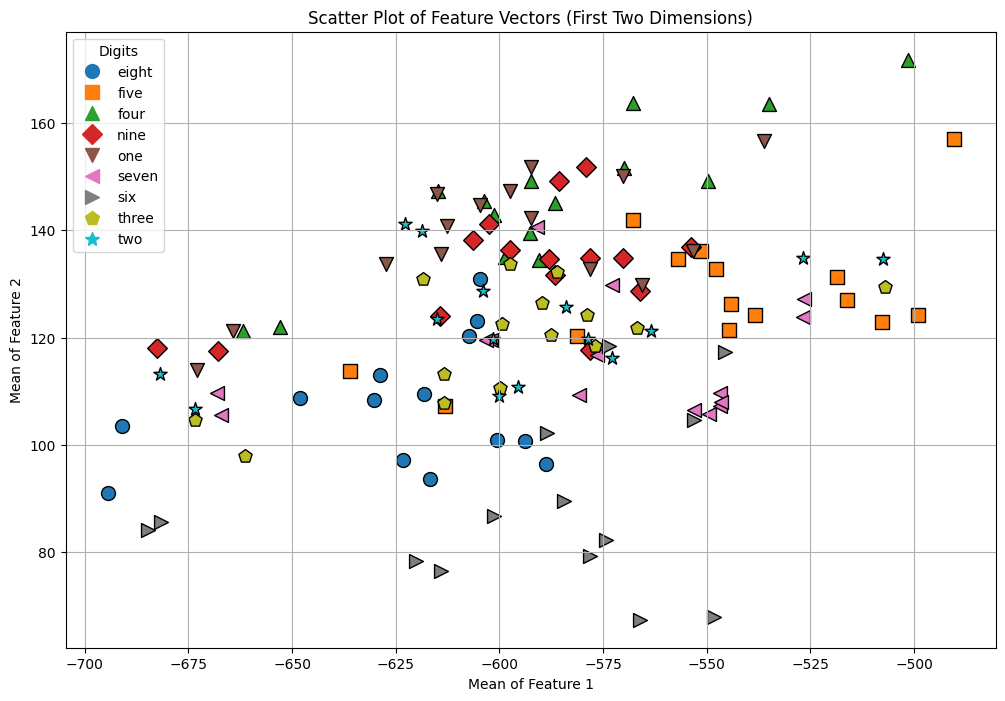

Variance Retained by the first two principal components: 20.06%


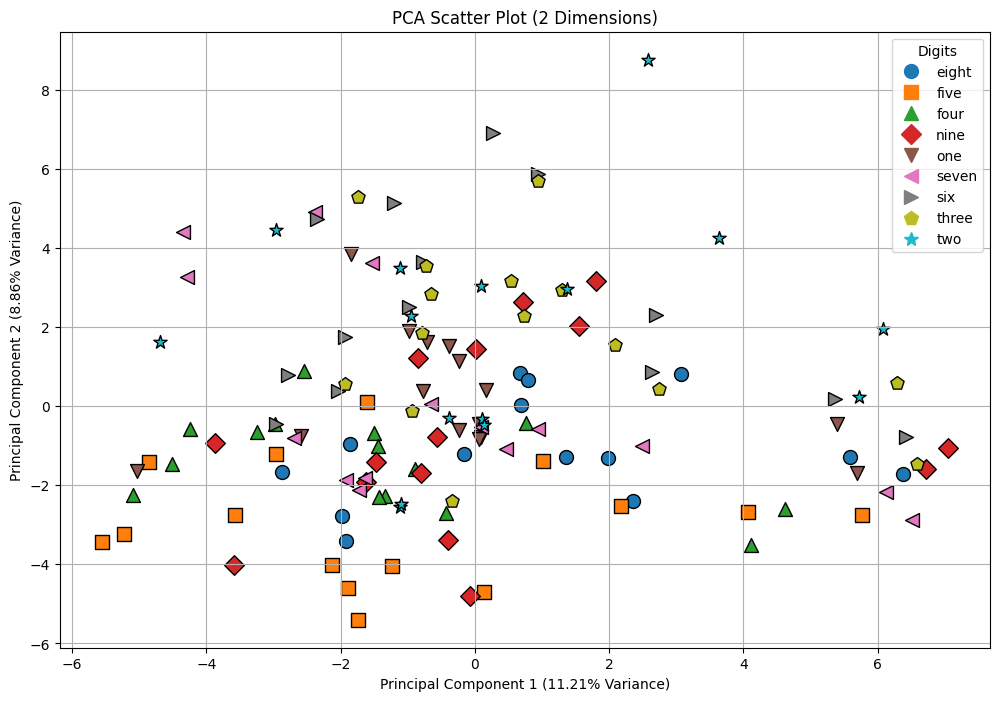

Variance Retained by the first three principal components: 26.67%


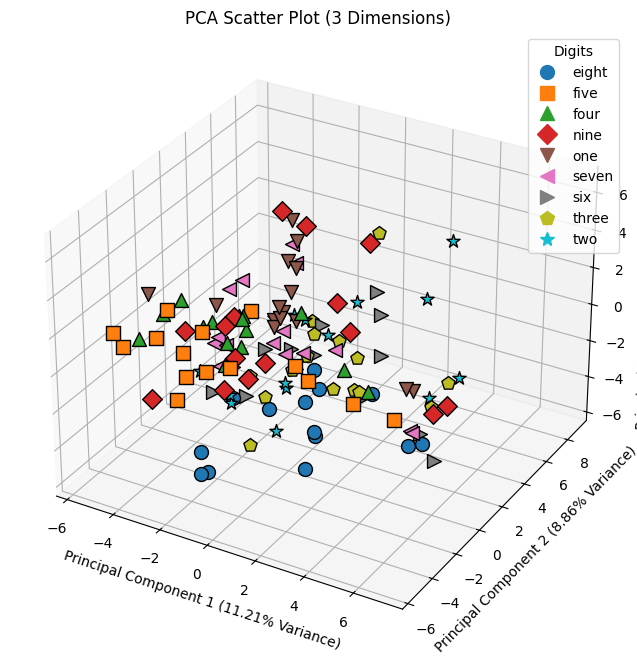

In [6]:
# Βήμα 6
import matplotlib.pyplot as plt
from step2 import data_parser
from step3 import extract_mfccs
from step5 import compute_feature_vectors, assign_colors_markers
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Step 2: Load data
wavs, speakers, digits = data_parser('./data/digits/')

# Step 3: Extract MFCCs
mfccs = extract_mfccs(wavs)

# Step 5: Compute feature vectors
feature_vectors, labels = compute_feature_vectors(mfccs)

'''
PCA Variance Retained
'''

def create_scaling_pca_pipeline(n_components=2):
    """
    Creates a scikit-learn Pipeline that scales the data and then applies PCA.

    Parameters:
    - n_components (int): Number of principal components to retain.

    Returns:
    - pipeline (sklearn.pipeline.Pipeline): The scaling and PCA pipeline.
    """
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components))
    ])
    return pipeline

# Initialize PCA with 2 components
pca_2 = create_scaling_pca_pipeline(n_components=2)

# Fit PCA on the feature vectors and transform the data
principal_components_2 = pca_2.fit_transform(feature_vectors)

# Retrieve the percentage of variance explained by each principal component from the pipeline
variance_2 = pca_2.named_steps['pca'].explained_variance_ratio_

print(f"Variance Retained by the first two principal components: {variance_2.sum()*100:.2f}%")

'''
PCA 2D Plot
'''

# Assign colors and markers to each digit
unique_digits, digit_to_color, digit_to_marker = assign_colors_markers(labels)


# Initialize the plot
plt.figure(figsize=(12, 8))

for idx, (pc1, pc2) in enumerate(principal_components_2):
    digit = labels[idx]
    color = digit_to_color[digit]
    marker = digit_to_marker[digit]
    plt.scatter(pc1, pc2, color=color, marker=marker, s=100, edgecolors='k')

# Create custom legend to avoid duplicate labels
handles = []
for digit in unique_digits:
    handles.append(plt.Line2D([], [], color=digit_to_color[digit], marker=digit_to_marker[digit],
                              linestyle='', markersize=10, label=digit))

plt.legend(handles=handles, title='Digits')
plt.title('PCA Scatter Plot (2 Dimensions)')
plt.xlabel(f'Principal Component 1 ({variance_2[0]*100:.2f}% Variance)')
plt.ylabel(f'Principal Component 2 ({variance_2[1]*100:.2f}% Variance)')
plt.grid(True)
# Save the plot
plt.savefig('images/pca_2d_plot.png')
plt.show()

'''
PCA 3D Plot
'''

# Initialize PCA with 3 components
pca_3 = create_scaling_pca_pipeline(n_components=3)

# Fit PCA on the feature vectors and transform the data
principal_components_3 = pca_3.fit_transform(feature_vectors)

# Retrieve the percentage of variance explained by each principal component
variance_3 = pca_3.named_steps['pca'].explained_variance_ratio_

print(f"Variance Retained by the first three principal components: {variance_3.sum()*100:.2f}%")

# Plot the 3D scatter plot

# Initialize the plot
fig = plt.figure(figsize=(12, 8))

# Create 3D axes
ax = fig.add_subplot(111, projection='3d')

for idx, (pc1, pc2, pc3) in enumerate(principal_components_3):
    digit = labels[idx]
    color = digit_to_color[digit]
    marker = digit_to_marker[digit]
    ax.scatter(pc1, pc2, pc3, color=color, marker=marker, s=100, edgecolors='k')
    
# Create custom legend to avoid duplicate labels
handles = []
for digit in unique_digits:
    handles.append(plt.Line2D([], [], color=digit_to_color[digit], marker=digit_to_marker[digit],
                              linestyle='', markersize=10, label=digit))
    
ax.legend(handles=handles, title='Digits')
ax.set_title('PCA Scatter Plot (3 Dimensions)')
ax.set_xlabel(f'Principal Component 1 ({variance_3[0]*100:.2f}% Variance)')
ax.set_ylabel(f'Principal Component 2 ({variance_3[1]*100:.2f}% Variance)')
ax.set_zlabel(f'Principal Component 3 ({variance_3[2]*100:.2f}% Variance)')
# Save the plot
plt.savefig('images/pca_3d_plot.png')
plt.show()




In [7]:
y_train

NameError: name 'y_train' is not defined

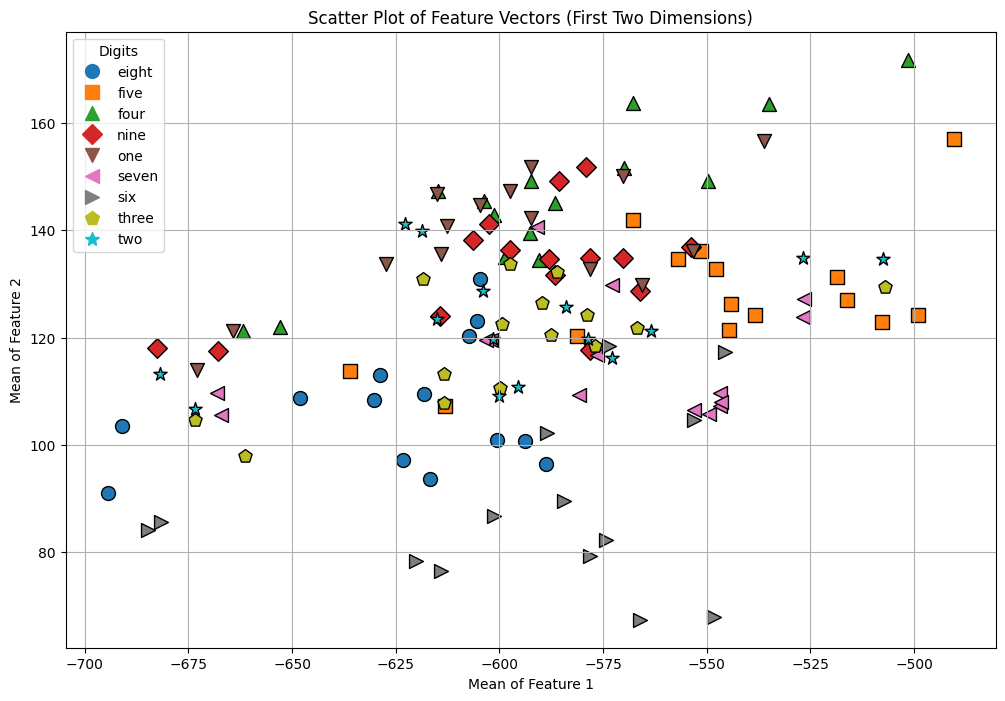


Custom Bayesian Classifier
Accuracy: 65.00%
F1 Score: 63.51%
Normalized confusion matrix
              precision    recall  f1-score   support

       eight       0.67      1.00      0.80         4
        five       0.44      1.00      0.62         4
        four       1.00      1.00      1.00         4
        nine       0.40      0.40      0.40         5
         one       0.50      0.40      0.44         5
       seven       1.00      0.40      0.57         5
         six       1.00      0.25      0.40         4
       three       1.00      0.75      0.86         4
         two       0.67      0.80      0.73         5

    accuracy                           0.65        40
   macro avg       0.74      0.67      0.65        40
weighted avg       0.73      0.65      0.64        40


Gaussian Naive Bayes Classifier
Accuracy: 65.00%
F1 Score: 63.51%
Normalized confusion matrix
              precision    recall  f1-score   support

       eight       0.67      1.00      0.80         4
 

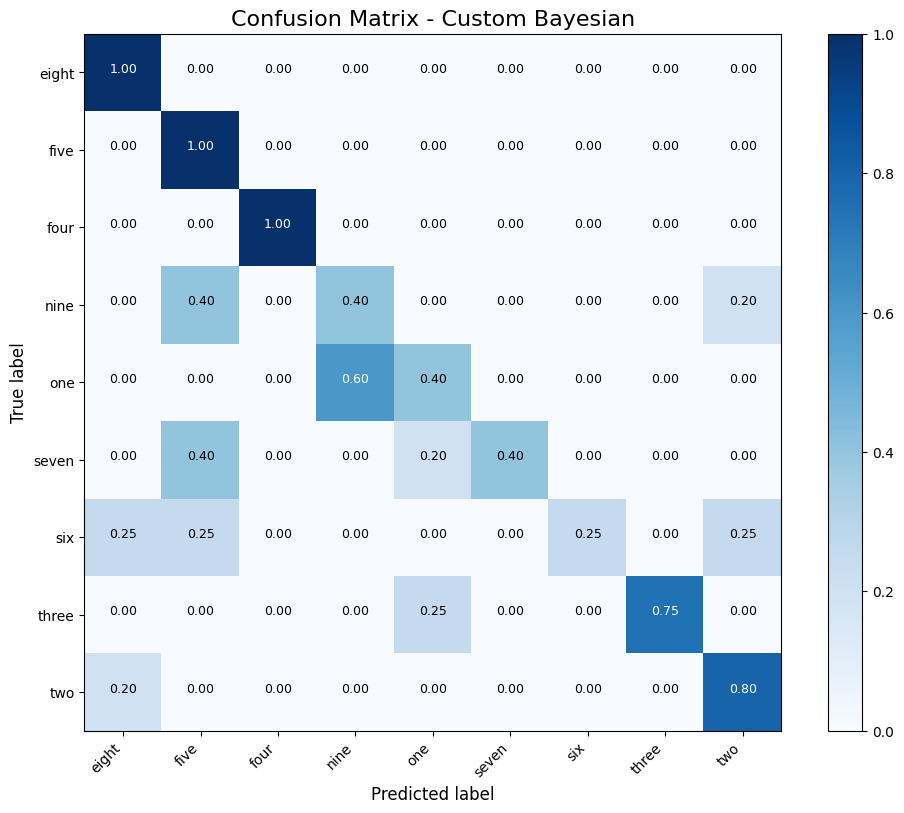

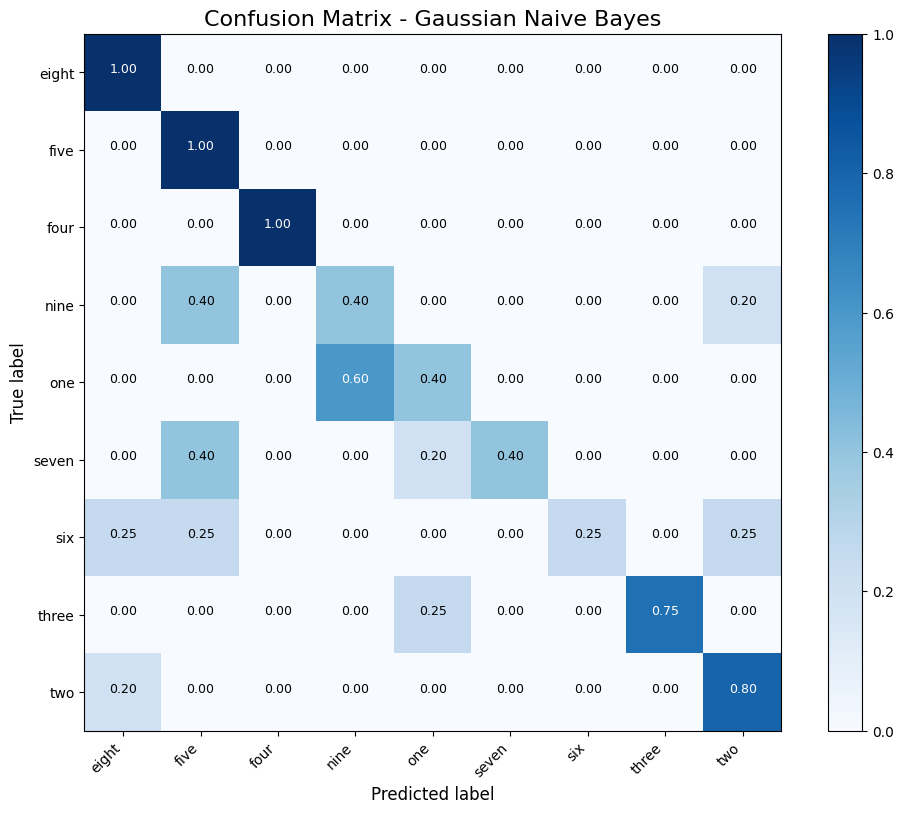

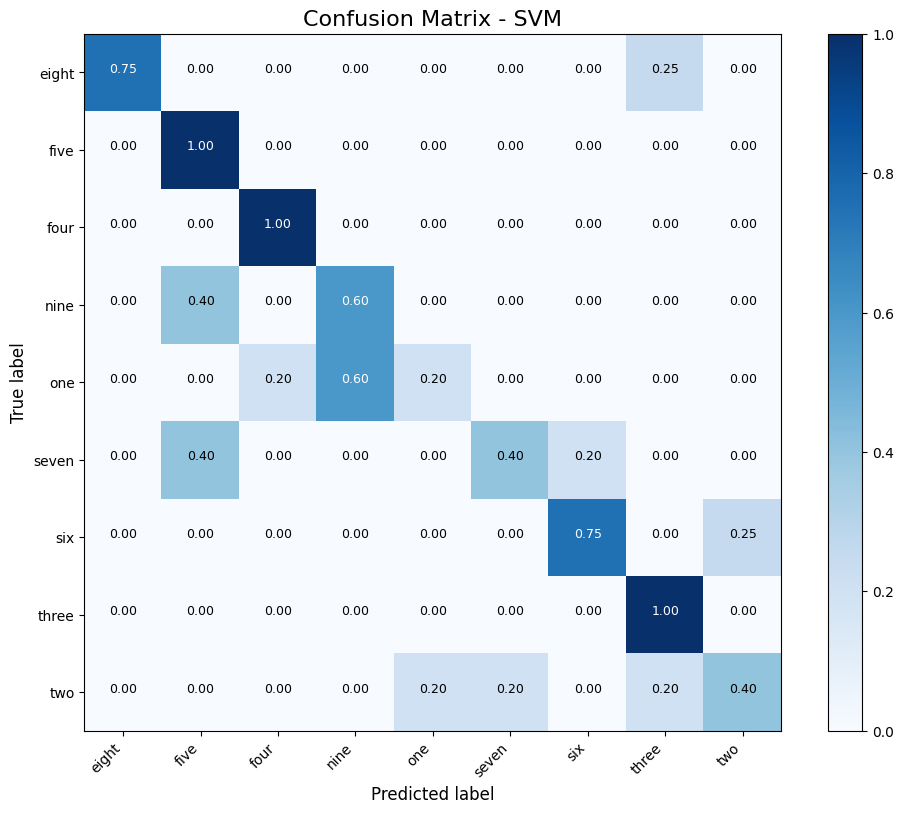

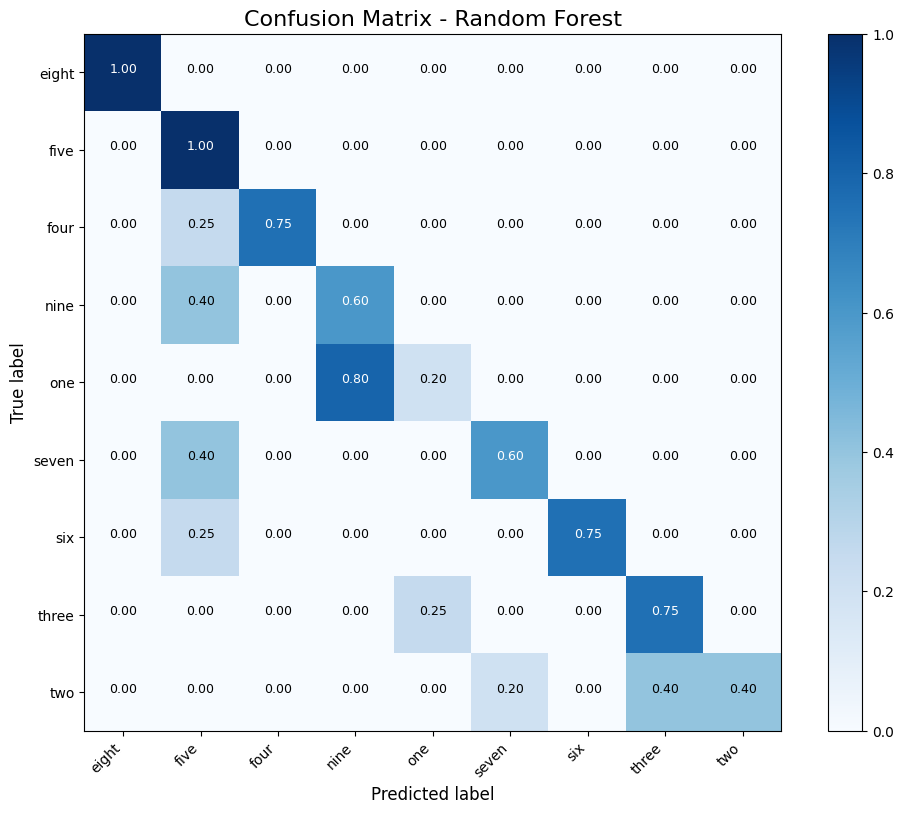

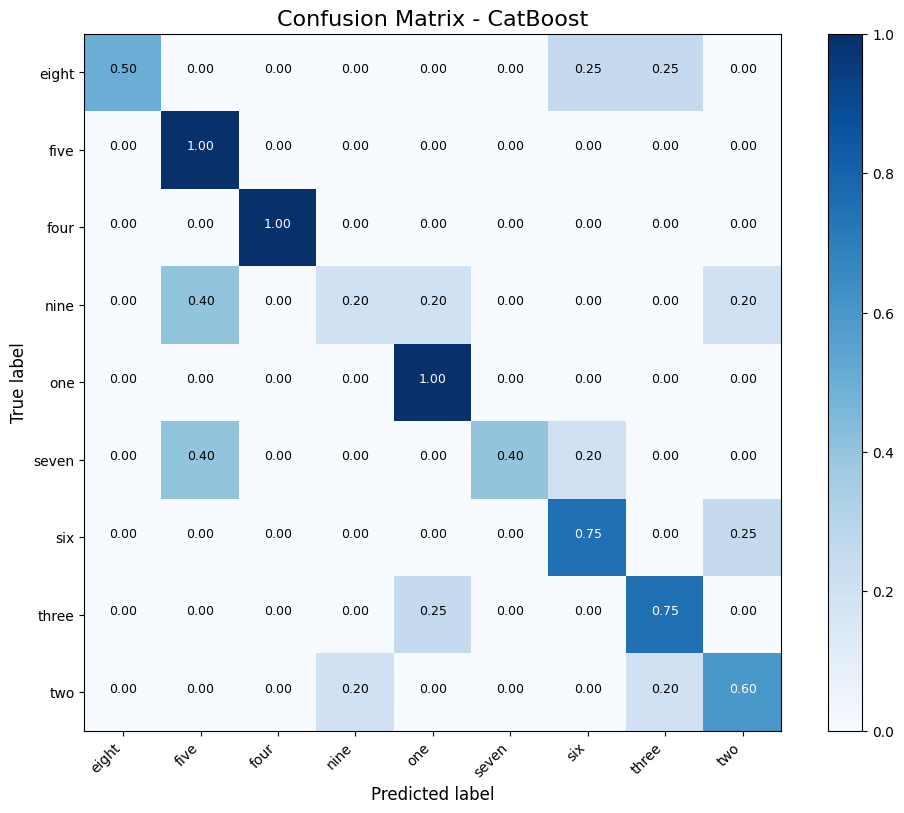

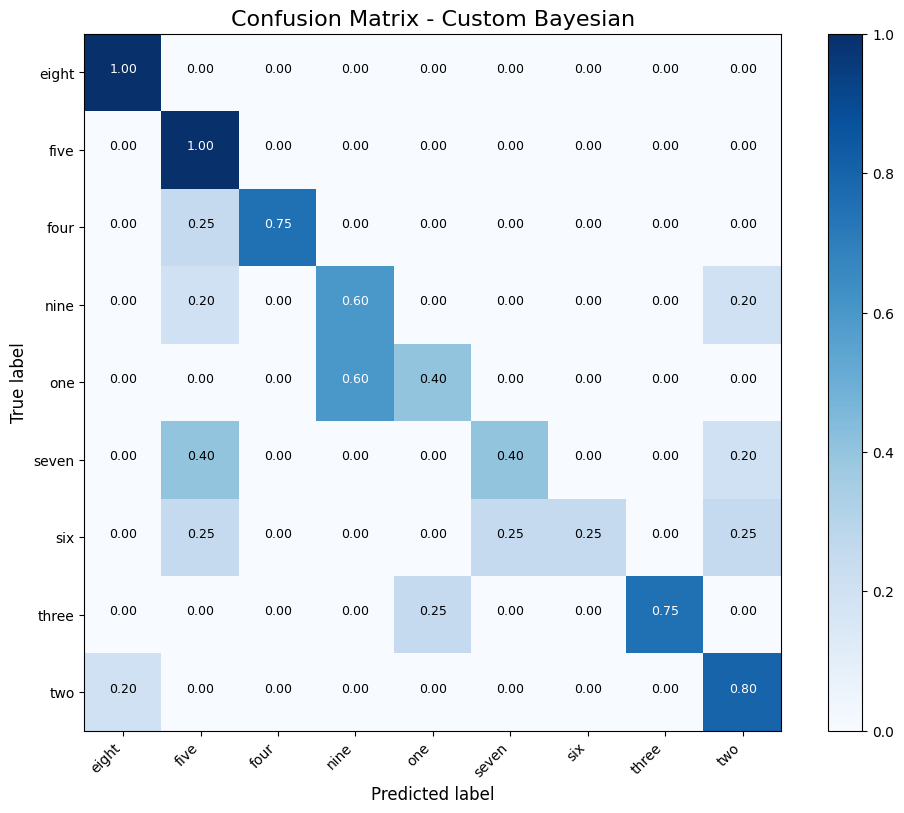

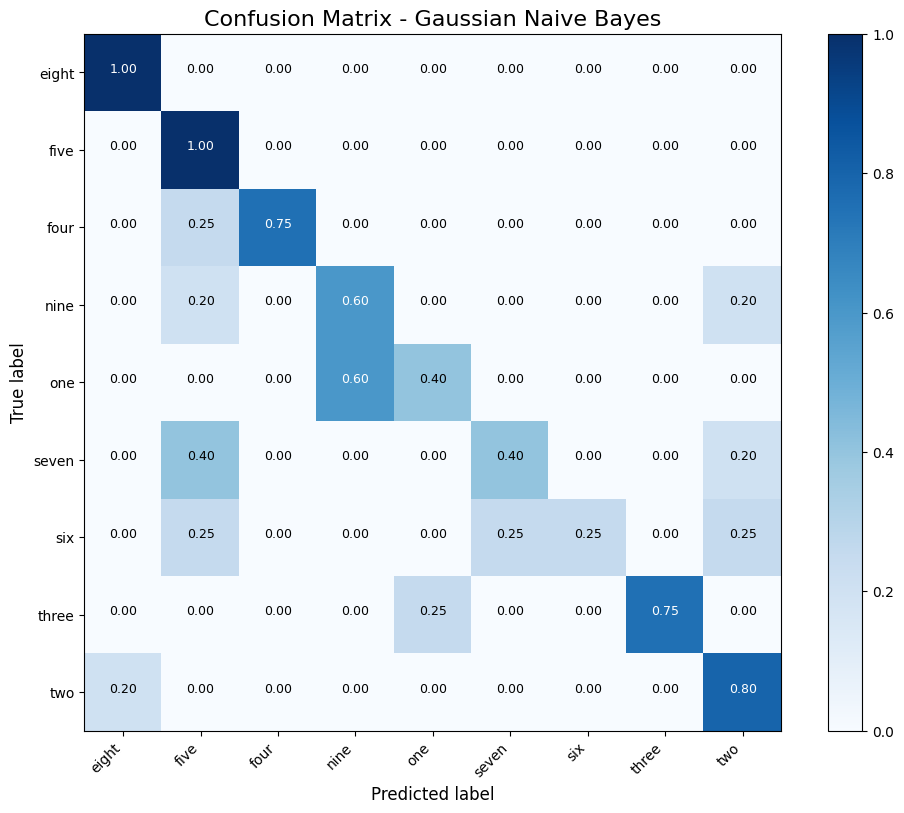

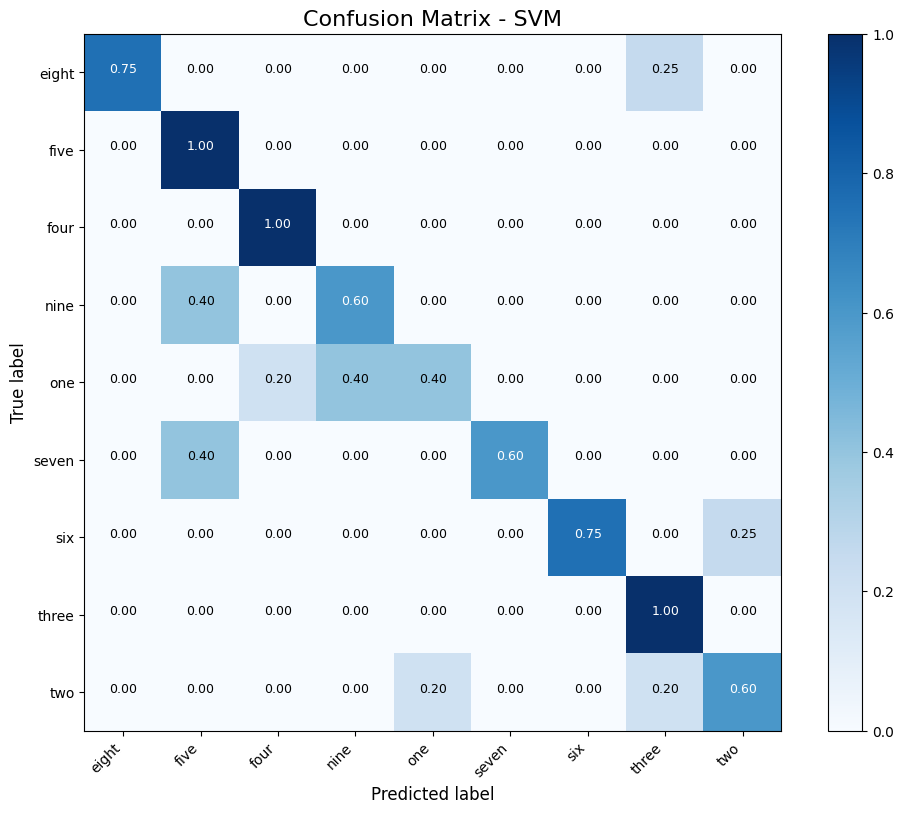

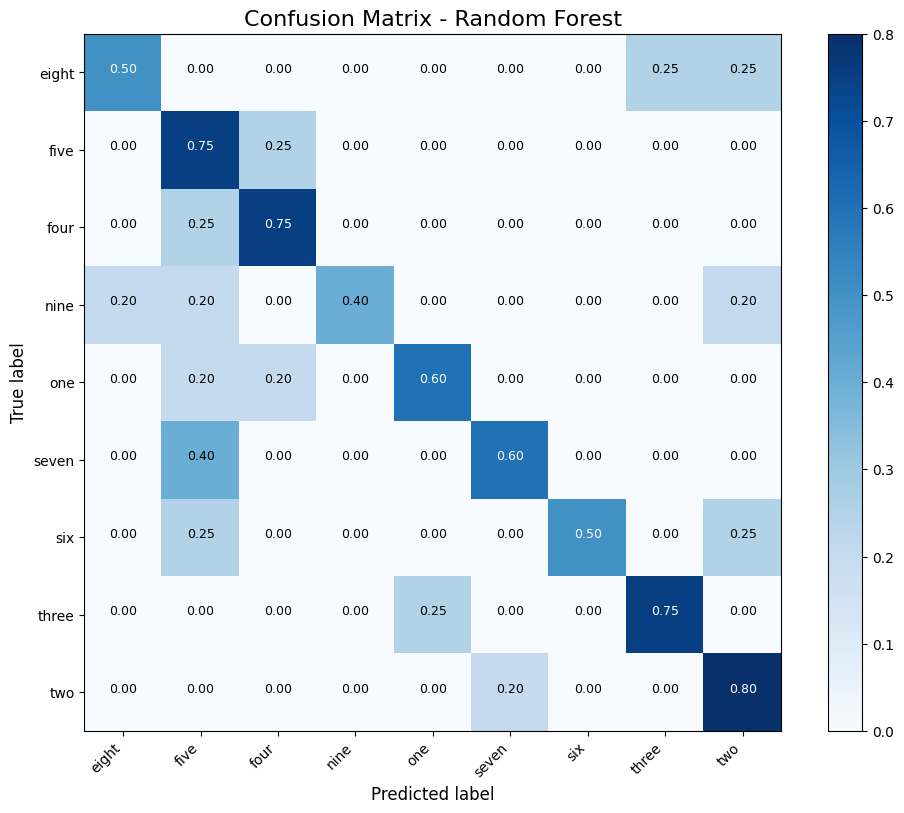

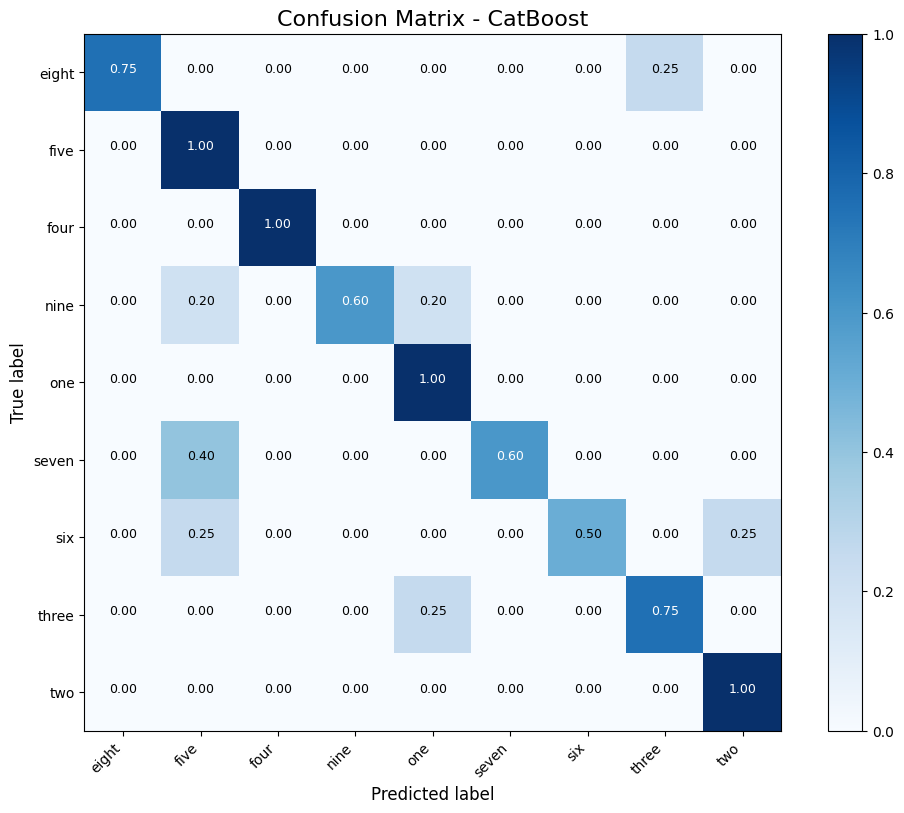

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import librosa
from plot_confusion_matrix import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
# import one-hot encoder

from step2 import data_parser
from step3 import extract_mfccs
from step5 import assign_colors_markers
from step5 import compute_feature_vectors
from sklearn.pipeline import Pipeline

# Step 2: Load data
wavs, speakers, digits = data_parser('./data/digits/')

# Step 3: Extract MFCCs
mfccs = extract_mfccs(wavs)

# Step 5: Compute feature vectors
feature_vectors, labels = compute_feature_vectors(mfccs)

unique_digits, digit_to_color, digit_to_marker = assign_colors_markers(labels)

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.3, random_state=42, stratify=labels)


'''
CustomBayesClassifier
'''

class CustomBayesClassifier:
    def __init__(self):
        self.classes = None
        self.priors = {}
        self.mean = {}
        self.var = {}
    
    def fit(self, X, y):
        """
        Fit the Bayesian classifier according to X, y.
        
        Parameters:
        - X (np.ndarray): Training feature vectors (num_samples, num_features).
        - y (list): Training labels.
        """
        self.classes = np.unique(y)
        for cls in self.classes:
            X_c = X[np.array(y) == cls]
            self.priors[cls] = X_c.shape[0] / X.shape[0]
            self.mean[cls] = np.mean(X_c, axis=0)
            self.var[cls] = np.var(X_c, axis=0) + 1e-9  # Add small value to prevent division by zero (var_smoothing)
    
    def _gaussian_log_prob(self, cls, x):
        """
        Calculate the log probability of x for class cls using Gaussian distribution.
        
        Parameters:
        - cls (str): Class label.
        - x (np.ndarray): Feature vector.
        
        Returns:
        - log_prob (float): Log probability.
        """
        mean = self.mean[cls]
        var = self.var[cls]
        # Calculate log Gaussian probability
        log_prob = -0.5 * np.sum(np.log(2. * np.pi * var))
        log_prob -= 0.5 * np.sum(((x - mean) ** 2) / var)
        return log_prob
    
    def predict(self, X):
        """
        Perform classification on an array of test vectors X.
        
        Parameters:
        - X (np.ndarray): Test feature vectors (num_samples, num_features).
        
        Returns:
        - predictions (list): Predicted class labels.
        """
        predictions = []
        for x in X:
            class_probs = {}
            for cls in self.classes:
                # Compute log prior + log likelihood
                class_probs[cls] = np.log(self.priors[cls]) + self._gaussian_log_prob(cls, x)
            # Select the class with the highest probability
            predicted_class = max(class_probs, key=class_probs.get)
            predictions.append(predicted_class)
        return predictions
    
    def score(self, X, y):
        """
        Return the mean accuracy on the given test data and labels.
        
        Parameters:
        - X (np.ndarray): Test feature vectors (num_samples, num_features).
        - y (list): True class labels.
        
        Returns:
        - score (float): Mean accuracy.
        """
        predictions = self.predict(X)
        return accuracy_score(y, predictions)


'''
Comparison with Gaussian Naive Bayes
'''

clfs = {
    'Custom Bayesian': CustomBayesClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'SVM': SVC(kernel='linear', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'CatBoost': CatBoostClassifier(n_estimators=100, random_state=42)
}

# Build pipelines for each classifier
pipelines = {}

for clf_name, clf in clfs.items():
    pipelines[clf_name] = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf)
    ])
    
# Keep resutls for each classifier in order to compare them
results = {}
    
# Train and evaluate each classifier
for clf_name, pipeline in pipelines.items():
    print(f"\n{clf_name} Classifier")
    # Train
    pipeline.fit(X_train, y_train)
    # Predict
    y_pred = pipeline.predict(X_test)
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    # Get f1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score: {f1 * 100:.2f}%")
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_digits)
    plot_confusion_matrix(conf_matrix, classes=unique_digits, title=f'Confusion Matrix - {clf_name}', normalize=True)
    # Classification report
    print(classification_report(y_test, y_pred, target_names=unique_digits))
    
    results[clf_name] = {'accuracy': accuracy, 'f1': f1}
    
# Compare classifiers based on accuracy and f1 score
print("\nComparison of Classifiers:")

# Get the best classifier based on accuracy
best_accuracy = max(results, key=lambda x: results[x]['accuracy'])
print(f"Best Classifier based on Accuracy: {best_accuracy}")

# Get the best classifier based on f1 score
best_f1 = max(results, key=lambda x: results[x]['f1'])
print(f"Best Classifier based on F1 Score: {best_f1}")

'''
Bonus
'''

def compute_feature_vectors_enhanced(mfccs, digits, wavs):
    """
    Processes audio files to extract enhanced feature vectors including MFCCs, deltas, delta-deltas,
    Zero-Crossing Rate (ZCR), and Spectral Centroid.
    
    Parameters:
    - mfccs (list): List of tuples, each containing MFCCs, deltas, and delta-deltas for an audio file.
    - digits (list): List of digit labels corresponding to each audio file.
    - wavs (list): List of waveform data for each audio file.
    
    Returns:
    - feature_vectors (np.ndarray): Array of enhanced feature vectors.
    - labels (list): List of digit labels corresponding to each feature vector.
    """
    
    feature_vectors = []
    labels = []
    
    for idx, ((mfcc, delta, delta2), wav) in enumerate(zip(mfccs, wavs)):
        # Concatenate MFCCs, Deltas, and Delta-Deltas
        combined_features = np.concatenate((mfcc, delta, delta2), axis=0)  # Shape: (39, frames)
        
        # Compute mean and standard deviation for each feature across all frames
        mean_features = np.mean(combined_features, axis=1)  # Shape: (39,)
        std_features = np.std(combined_features, axis=1)    # Shape: (39,)
        
        # Compute Zero-Crossing Rate (ZCR)
        zcr = librosa.feature.zero_crossing_rate(y=wav)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)
        
        # Compute Spectral Centroid
        spectral_centroid = librosa.feature.poly_features(y=wav, sr=16000, hop_length=20, win_length=25, order=3)
        spectral_centroid_mean = np.mean(spectral_centroid)
        spectral_centroid_std = np.std(spectral_centroid)
        
        # Concatenate all features into a single vector
        feature_vector = np.concatenate((
            mean_features,       # 39
            std_features,        # 39
            [zcr_mean, zcr_std], # 2
            [spectral_centroid_mean, spectral_centroid_std] # 2
        ))  # Total length: 39 + 39 + 2 + 2 = 82
        
        feature_vectors.append(feature_vector)
        labels.append(digits[idx])
    
    feature_vectors = np.array(feature_vectors)
    return feature_vectors, labels


# Step 5: Compute feature vectors
feature_vectors, labels = compute_feature_vectors_enhanced(mfccs, digits, wavs)

# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.3, random_state=42, stratify=labels)

for clf_name, pipeline in pipelines.items():
    print(f"\n{clf_name} Classifier")
    # Train
    pipeline.fit(X_train, y_train)
    # Predict
    y_pred = pipeline.predict(X_test)
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    # Get f1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1 Score: {f1 * 100:.2f}%")
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=unique_digits)
    plot_confusion_matrix(conf_matrix, classes=unique_digits, title=f'Confusion Matrix - {clf_name}', normalize=True)
    # Classification report
    print(classification_report(y_test, y_pred, target_names=unique_digits))
    
    results[clf_name] = {'accuracy': accuracy, 'f1': f1}
    
    
# Compare classifiers based on accuracy and f1 score
print("\nComparison of Classifiers:")

# Get the best classifier based on accuracy
best_accuracy = max(results, key=lambda x: results[x]['accuracy'])
print(f"Best Classifier based on Accuracy: {best_accuracy}")

# Get the best classifier based on f1 score
best_f1 = max(results, key=lambda x: results[x]['f1'])
print(f"Best Classifier based on F1 Score: {best_f1}")
